In [1]:
import os
import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras as K
import pandas as pd
import models

import matplotlib.pyplot as plt

from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_curve, auc
import itertools
from tqdm import tqdm
from random import sample

In [11]:
batch_size = 1024
epochs = 30
model_arch = 'mlp'
bl = 0

In [3]:
model_dir = '../models/'
hist_dir = '../histories/'
plot_dir = '../plots/'
dataset_dir = '../dataset/'
model_name = model_arch

In [4]:
os.makedirs(model_dir, exist_ok=True)
os.makedirs(hist_dir, exist_ok=True)

In [5]:
# Read the datasets
files = [f for f in os.listdir(dataset_dir) if f.endswith("h5")]
print(files)

['RS.h5', 'WS.h5', 'sidebands.h5']


In [6]:
input_data = []
labels = []
for name in tqdm(files):
    print("Reading file", name)
    pions1 = pd.read_hdf(dataset_dir + name, 'pion1').values
    pions2 = pd.read_hdf(dataset_dir + name, 'pion2').values
    addinfo = pd.read_hdf(dataset_dir + name, 'add_info').values

    file_inputs = np.concatenate([np.reshape(addinfo[:,1], (-1,1)), pions1, pions2], axis=1)
    input_data.append(file_inputs)
    labels.append(addinfo[:,2])

  0%|          | 0/3 [00:00<?, ?it/s]

Reading file RS.h5


 33%|███▎      | 1/3 [00:00<00:00,  2.09it/s]

Reading file WS.h5


 67%|██████▋   | 2/3 [00:00<00:00,  2.07it/s]

Reading file sidebands.h5


100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


In [7]:
if(bl==1):
    model_name = model_name + '_bldata'
    balanced_samples = 0
    for label_array in labels:
        classes, counts = np.unique(label_array, return_counts=True)
        if(len(classes)==2):
            balanced_samples = np.min(counts)

    balanced_input_data = []
    balanced_labels = []
    for i in range(len(labels)):
        classes = np.unique(labels[i])
        if(len(classes)==2):
            balanced_input_data.append(input_data[i][:int(balanced_samples+(balanced_samples/3))])
            balanced_labels.append(labels[i][:int(balanced_samples+(balanced_samples/3))])
        else:
            samp = sample(range(len(labels[i])), int(balanced_samples/3))
            temp_samples = [input_data[i][k] for k in samp]
            temp_labels = [labels[i][k] for k in samp]
            balanced_input_data.append(temp_samples)
            balanced_labels.append(temp_labels)    
    
    input_data = balanced_input_data
    labels = balanced_labels

In [8]:
# Now create input/output
input_array = np.array([item for sublist in input_data for item in sublist])
output_array = np.array([item for sublist in labels for item in sublist])

num_features = int((input_array.shape[1]-1)/2)

In [9]:
input_array, output_array = shuffle(input_array, output_array)

print('****************')
print('TOTAL SAMPLES: ', len(output_array))
classes, counts = np.unique(output_array, return_counts=True)
print(classes, counts)

# Split the dataset in train and test
x_train, x_test, y_train, y_test = train_test_split(input_array, output_array, test_size=0.2)

print('TRAIN SAMPLES : ', y_train)
classes, counts = np.unique(y_train, return_counts=True)
print(classes, counts)

print('TEST SAMPLES : ', y_test)
classes, counts = np.unique(y_test, return_counts=True)
print(classes, counts)
print('****************')

****************
TOTAL SAMPLES:  947169
[0. 1.] [940577   6592]
TRAIN SAMPLES :  [0. 0. 0. ... 0. 0. 0.]
[0. 1.] [752442   5293]
TEST SAMPLES :  [0. 0. 0. ... 0. 0. 0.]
[0. 1.] [188135   1299]
****************


In [12]:
model = getattr(models, model_arch)(num_features)
model.summary()

Model: "MLP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24)           0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24)           96          concatenate[0][0]              

In [13]:
if(bl==0):
    weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)    
    history = model.fit([x_train[:,1:num_features+1], x_train[:,num_features+1:], x_train[:,0]], y_train, batch_size=batch_size, epochs=epochs, class_weight=dict(enumerate(weights)), validation_split=0.1, callbacks=[K.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)], shuffle=True, verbose=1)
else:
    history = model.fit([x_train[:,1:num_features+1], x_train[:,num_features+1:], x_train[:,0]], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[K.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)], shuffle=True, verbose=1)

/lustrehome/slezki/.local/share/anaconda3/envs/pienv/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/30
666/666 [==============================] - 6s 9ms/step - loss: 0.6148 - accuracy: 0.5800 - val_loss: 0.5959 - val_accuracy: 0.6868
Epoch 2/30
666/666 [==============================] - 6s 9ms/step - loss: 0.4390 - accuracy: 0.7452 - val_loss: 0.4578 - val_accuracy: 0.7853
Epoch 3/30
666/666 [==============================] - 6s 9ms/step - loss: 0.2953 - accuracy: 0.8137 - val_loss: 0.3261 - val_accuracy: 0.8648
Epoch 4/30
666/666 [==============================] - 6s 9ms/step - loss: 0.1720 - accuracy: 0.9572 - val_loss: 0.1908 - val_accuracy: 0.9487
Epoch 5/30
666/666 [==============================] - 6s 9ms/step - loss: 0.1241 - accuracy: 0.9814 - val_loss: 0.0976 - val_accuracy: 0.9932
Epoch 6/30
666/666 [==============================] - 6s 9ms/step - loss: 0.1056 - accuracy: 0.9858 - val_loss: 0.0984 - val_accuracy: 0.9863
Epoch 7/30
666/666 [==============================] - 6s 9ms/step - loss: 0.0944 - accuracy: 0.9871 - val_loss: 0.0847 - val_accuracy: 0.9912
Epoch 

In [14]:
# Save the history for accuracy/loss plots
history_df = pd.DataFrame(history.history)
history_df.to_hdf(hist_dir + model_name + '_history.h5', "history", append=False)

plot_dir = plot_dir + model_name +'/'
os.makedirs(plot_dir, exist_ok=True)

# Save model and weights
model.save(model_dir + model_name + '.h5')

In [15]:
# Now evaluate the model performance
results = model.predict([x_test[:,1:num_features+1], x_test[:,num_features+1:], x_test[:,0]])
results = np.reshape(results, -1)

In [18]:
# Define metrics calculate values
precision = K.metrics.Precision()
recall = K.metrics.Recall()
accuracy = K.metrics.Accuracy()

precision.update_state(y_test, results)
recall.update_state(y_test, results)
accuracy.update_state(y_test, np.rint(results))

precision_value = precision.result().numpy()
recall_value = recall.result().numpy()
f1_value = (2 * precision_value * recall_value)/(precision_value + recall_value)
accuracy_value = accuracy.result().numpy()
balanced_accuracy = balanced_accuracy_score(y_test, np.rint(results))

score_names = ['Precision', 'Recall', 'F1', 'Accuracy', 'BalancedAccuracy']
scores = [precision_value, recall_value, f1_value, accuracy_value, balanced_accuracy]

print('Precision: {}'.format(precision_value))
print('Recall: {}'.format(recall_value))
print('F1: {}'.format(f1_value))
print('Accuracy: {}'.format(accuracy_value))
print('BalancedAccuracy: {}'.format(balanced_accuracy))

Precision: 0.798256516456604
Recall: 0.9869130253791809
F1: 0.8826161425213153
Accuracy: 0.9981998801231384
BalancedAccuracy: 0.9925954212076389


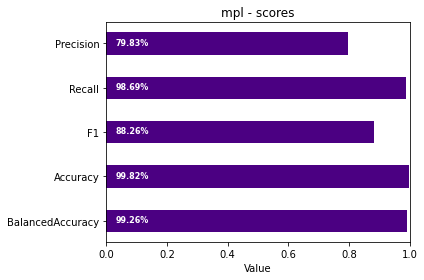

In [19]:
# Plot the scores
percentages = ['{:.2f}'.format(k*100) for k in scores]

fig = plt.figure()
y_pos = np.arange(len(score_names))
plt.barh(y_pos, scores, height= 0.5, align='center', color='indigo')
for i in range(len(scores)):
    plt.text(0.03, y_pos[i]+0.03, percentages[i]+'%', color='white', weight='bold', fontsize=8)

plt.xlim(0, 1)
plt.yticks(y_pos, score_names)
plt.gca().invert_yaxis()
plt.xlabel('Value')
plt.title(model_name + ' - scores')
plt.tight_layout()
plt.savefig(plot_dir + 'scores.png', format='png')
plt.show()

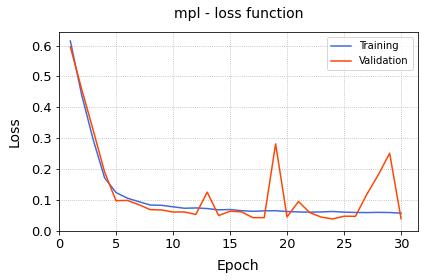

In [20]:
# Plot the loss function
plt.figure()
epochs = np.arange(1, len(history_df)+1)

train_loss = history_df['loss']
val_loss = history_df['val_loss']

plt.plot(epochs, train_loss, '-', color='royalblue', label='Training')
plt.plot(epochs, val_loss, '-', color='orangered', label='Validation')
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.title(model_name + ' - loss function', y=1.04, fontsize=14)
plt.grid(linestyle=':')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + 'train_loss.png', format='png')
plt.show()

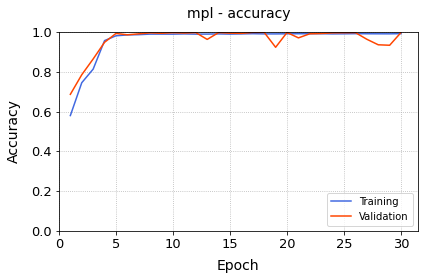

In [21]:
# Plot accuracy
plt.figure()
epochs = np.arange(1, len(history_df)+1)

train_acc = history_df['accuracy']
val_acc = history_df['val_accuracy']

plt.plot(epochs, train_acc, '-', color='royalblue', label='Training')
plt.plot(epochs, val_acc, '-', color='orangered', label='Validation')
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.title(model_name + ' - accuracy', y=1.04, fontsize=14)
plt.grid(linestyle=':')
plt.xlim(left=0)
plt.ylim(top=1, bottom=0)
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Accuracy', labelpad=10, fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(plot_dir + 'accuracy.png', format='png')
plt.show()

In [22]:
# Define and compute the confusion matrix
def plot_confusion_matrix(cm, classes, title=model_name + ' - confusion matrix', cmap=plt.cm.YlGnBu):
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=13, y=1.04)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.ylabel('True class', labelpad=10, fontsize=13)
    plt.xlabel('Predicted class', labelpad=10, fontsize=13)
    plt.tight_layout()

[[1.   0.  ]
 [0.01 0.99]]


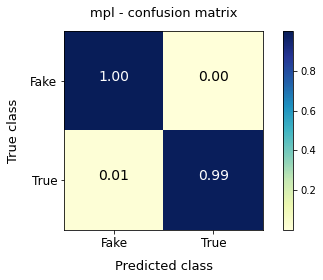

In [23]:
class_names = ['Fake', 'True']
cnf_matrix = confusion_matrix(y_test, np.rint(results), normalize='true')
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title= model_name + ' - confusion matrix')
plt.savefig(plot_dir + 'confusion_matrix.png', format='png')
plt.show()

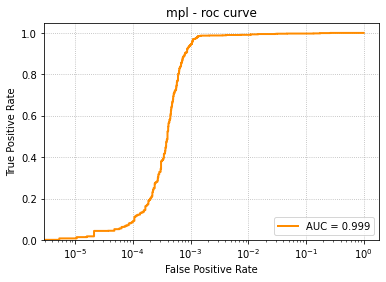

In [24]:
# Plot the roc curve
plt.figure()
fpr, tpr, _ = roc_curve(y_test, results)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.3f' % roc_auc)
#plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(model_name + ' - roc curve')
plt.grid(ls=':')
plt.legend(loc="lower right")
plt.savefig(plot_dir + 'roc_curve.png', format='png')
plt.show()